# XGBoost Algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# Import Data

In [3]:
df = pd.read_csv("data/500Dataset_Welltest.csv", index_col="ID")
df.head()

,Generator,Status,Result Status,Proxy Role,Keep SR2,Has SR2,Highlight,RESPRES,OIL_RATE,BO,VISC,THICKNEES,BHP,SLOPE,K,Execution Node,Dataset Path,Optimal,Comment
ID,,,,,,,,,,,,,,,,,,,
0,Reuse,Reused,NormalTermination,Ignore,Yes,True,False,6009,2500,1.210,0.92,23.0,5904.1364,226.552003,86.630000,NaN,BUILDUP.dat,False,NaN
1,CMG DECE,Complete,NormalTermination,Training,Auto,False,False,5859,2350,1.192,0.81,24.6,5767.5236,196.544312,76.117480,LAPTOP-N92NEVSN,WELLTEST_SIMULATION.cmsd\WELLTEST_SIMULATION_0...,False,Initialization
2,CMG DECE,Complete,NormalTermination,Training,Auto,False,False,6109,2450,1.120,0.96,24.2,6011.9133,212.310982,83.160744,LAPTOP-N92NEVSN,WELLTEST_SIMULATION.cmsd\WELLTEST_SIMULATION_0...,False,Initialization
3,CMG DECE,Complete,NormalTermination,Training,Auto,False,False,5909,2550,1.138,0.75,23.8,5805.7624,207.352839,71.533193,LAPTOP-N92NEVSN,WELLTEST_SIMULATION.cmsd\WELLTEST_SIMULATION_0...,False,Initialization
4,CMG DECE,Complete,NormalTermination,Training,Auto,False,False,6109,2500,1.210,0.93,25.0,6013.2990,213.979503,85.299600,LAPTOP-N92NEVSN,WELLTEST_SIMULATION.cmsd\WELLTEST_SIMULATION_0...,False,Initialization


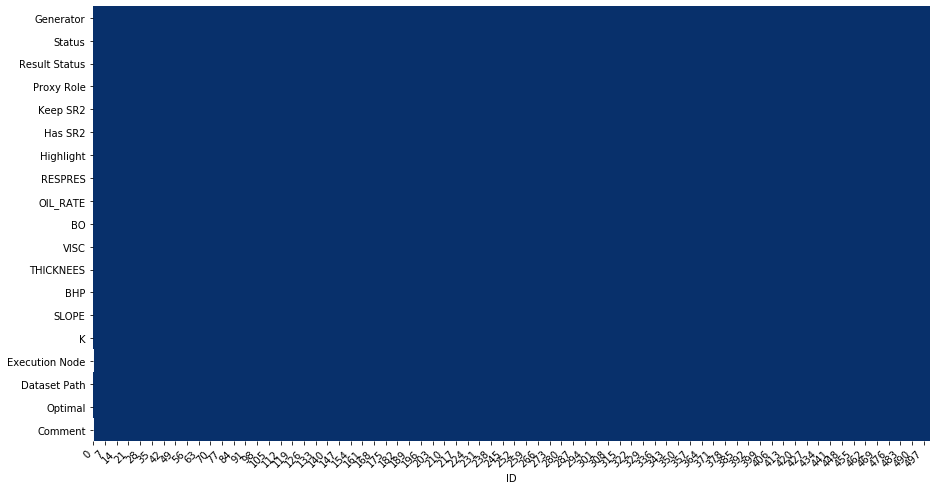

In [4]:
plot_missing_value(df)

In [5]:
## Di drop dahulu data yang tidak digunakan

In [6]:
df.columns

Index(['Generator', 'Status', 'Result Status', 'Proxy Role', 'Keep SR2',
       'Has SR2', 'Highlight', 'RESPRES', 'OIL_RATE', 'BO', 'VISC',
       'THICKNEES', 'BHP', 'SLOPE', 'K', 'Execution Node', 'Dataset Path',
       'Optimal', 'Comment'],
      dtype='object')

In [7]:
df.drop(columns = (['Generator', 'Status', 'Result Status', 'Proxy Role', 'Keep SR2',
       'Has SR2', 'Highlight', 'BHP', 'Execution Node', 'Dataset Path',
       'Optimal', 'Comment']), inplace = True)

In [8]:
df.head()

,RESPRES,OIL_RATE,BO,VISC,THICKNEES,SLOPE,K
ID,,,,,,,
0,6009,2500,1.210,0.92,23.0,226.552003,86.630000
1,5859,2350,1.192,0.81,24.6,196.544312,76.117480
2,6109,2450,1.120,0.96,24.2,212.310982,83.160744
3,5909,2550,1.138,0.75,23.8,207.352839,71.533193
4,6109,2500,1.210,0.93,25.0,213.979503,85.299600


In [9]:
df.drop(columns = (['SLOPE']), inplace = True)

In [10]:
df.head()

,RESPRES,OIL_RATE,BO,VISC,THICKNEES,K
ID,,,,,,
0,6009,2500,1.210,0.92,23.0,86.630000
1,5859,2350,1.192,0.81,24.6,76.117480
2,6109,2450,1.120,0.96,24.2,83.160744
3,5909,2550,1.138,0.75,23.8,71.533193
4,6109,2500,1.210,0.93,25.0,85.299600


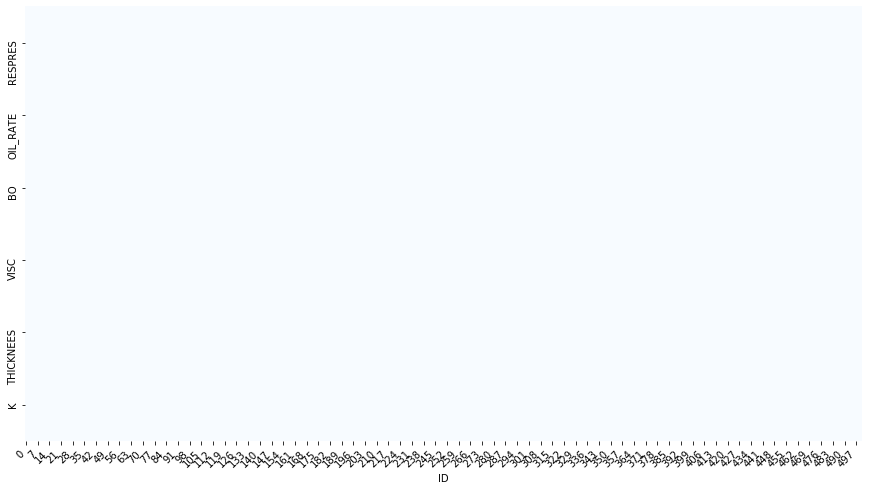

In [11]:
plot_missing_value(df)

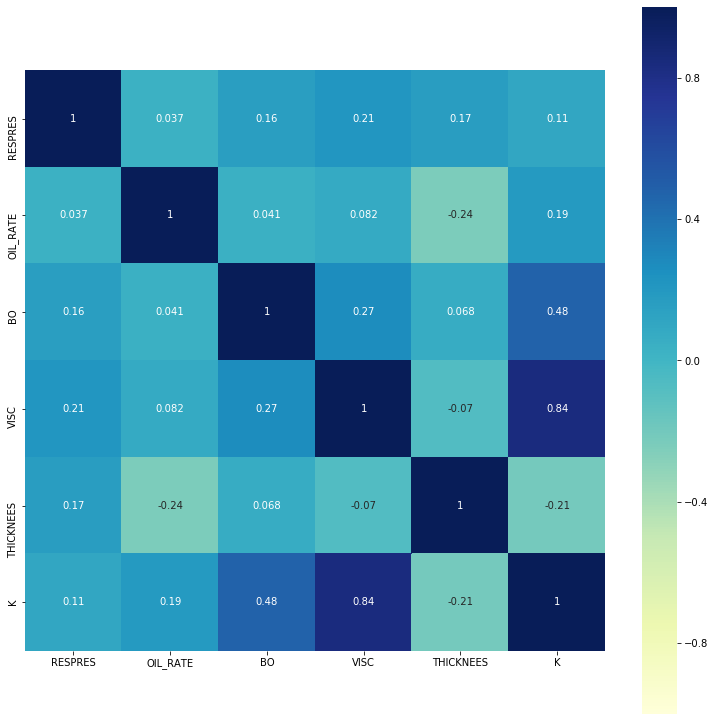

In [12]:
plt.figure(figsize=(13, 13))
sns.heatmap(df.corr(), cmap='YlGnBu', cbar='False', vmin=-1, vmax=1, annot=True, square=True)

In [13]:
df.head()

,RESPRES,OIL_RATE,BO,VISC,THICKNEES,K
ID,,,,,,
0,6009,2500,1.210,0.92,23.0,86.630000
1,5859,2350,1.192,0.81,24.6,76.117480
2,6109,2450,1.120,0.96,24.2,83.160744
3,5909,2550,1.138,0.75,23.8,71.533193
4,6109,2500,1.210,0.93,25.0,85.299600


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017897B9EDC8>,
      dtype=object)

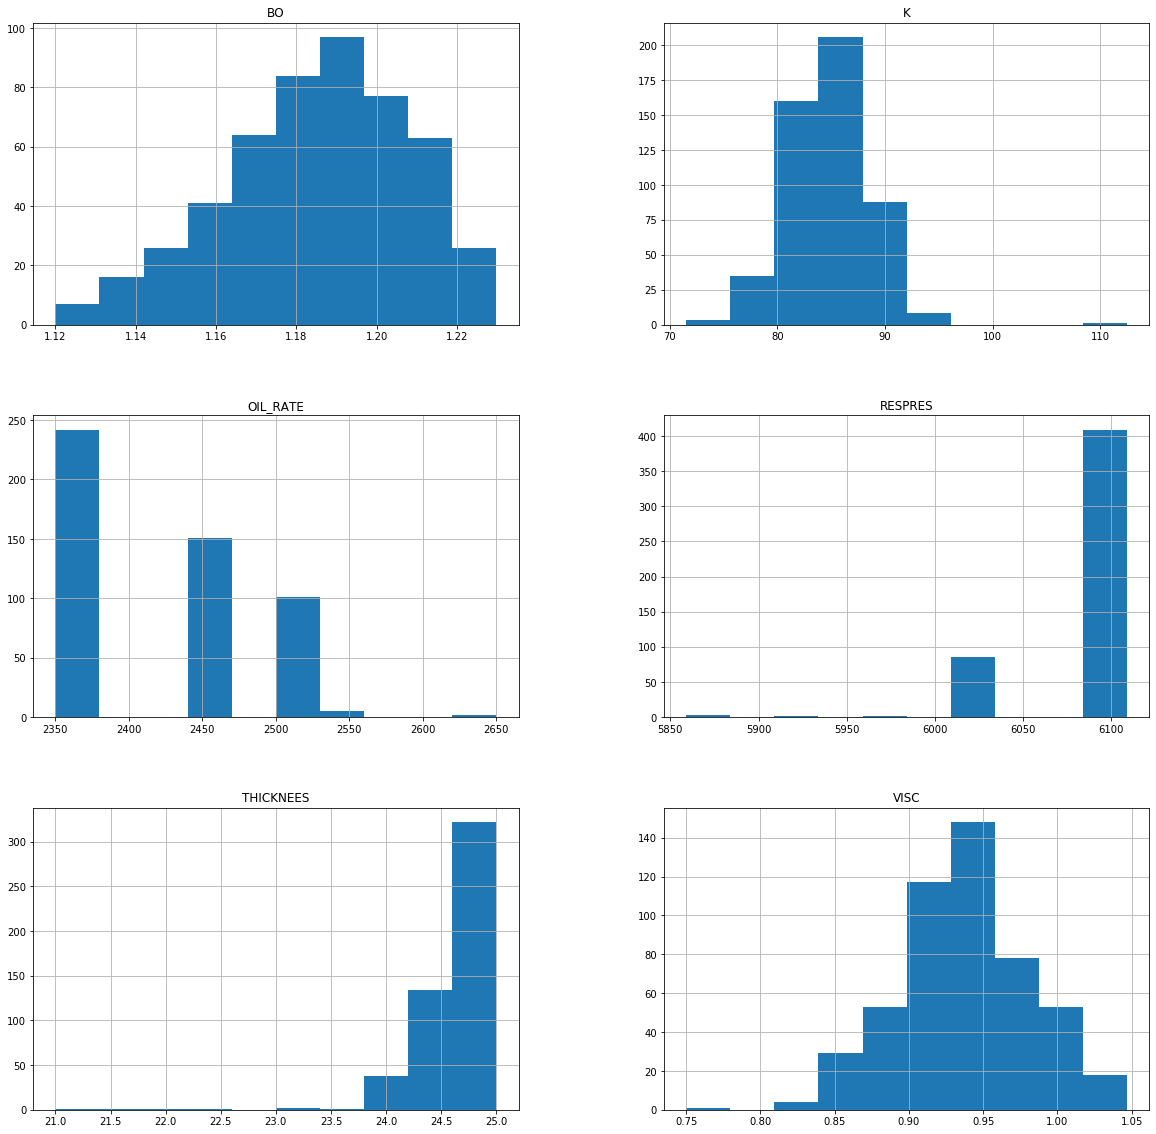

In [14]:
df.hist(figsize=(20, 20))

In [15]:
# Data Splitting

In [16]:
X = df.drop(columns="K")
y = df.K

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 5), (101, 5), (400,), (101,))

In [17]:
# Training

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [19]:
X_train.columns

Index(['RESPRES', 'OIL_RATE', 'BO', 'VISC', 'THICKNEES'], dtype='object')

In [20]:
rsp.xgb_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [21]:
#R-Square

In [22]:
#Polynomial

In [23]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['RESPRES', 'OIL_RATE', 'BO', 'VISC', 'THICKNEES']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s


{'algo__colsample_bytree': 0.7273141668957412, 'algo__gamma': 6, 'algo__learning_rate': 0.05235791002299295, 'algo__max_depth': 10, 'algo__n_estimators': 125, 'algo__reg_alpha': 1.739616742284701, 'algo__reg_lambda': 2.9396070097391545, 'algo__subsample': 0.7566202762782357, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': True}
0.8977312188303401 0.7244072201027979 0.9220219689235147


[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:    3.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.9s finished


In [24]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8977312188303401, 0.9220219689235147)

In [25]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

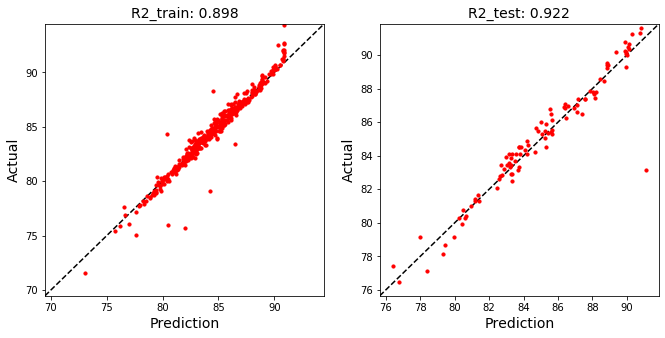

In [26]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

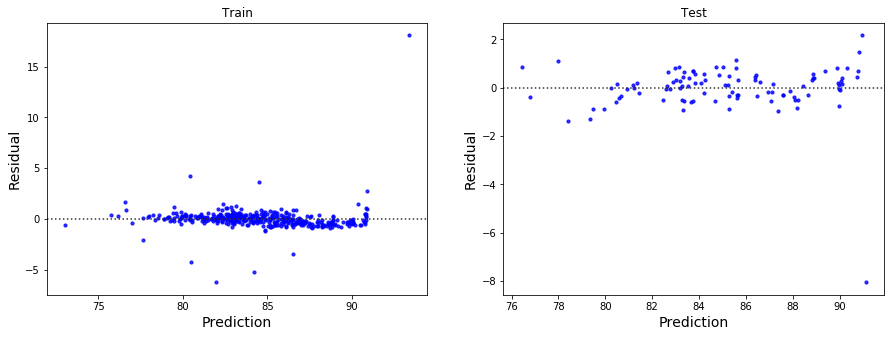

In [27]:
plot_residual(X_train, y_train, X_test, y_test, model)

In [28]:
### Kesimpulan: polynomial memperbaiki model menjadi lebih baik

In [29]:
from jcopml.feature_importance import  mean_loss_decrease
from jcopml.feature_importance import mean_score_decrease

In [30]:
# Prediction

In [31]:
X_train.iloc[:1]

,RESPRES,OIL_RATE,BO,VISC,THICKNEES
ID,,,,,
386,6009,2350,1.1704,0.9615,24.76


In [32]:
X_pred = pd.DataFrame([[6009, 2500, 1.21, 0.92, 23]], columns=X_train.columns)
X_pred

,RESPRES,OIL_RATE,BO,VISC,THICKNEES
0,6009,2500,1.21,0.92,23


In [33]:
model.predict(X_pred)

array([87.085365], dtype=float32)

In [34]:
## Mean Loss Decrease

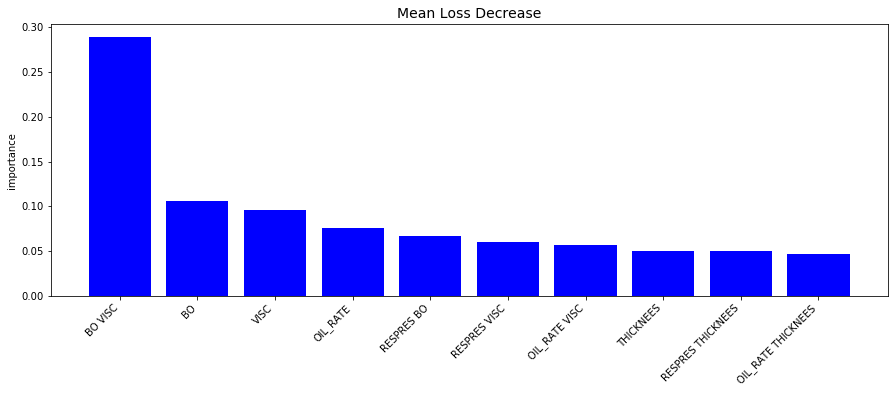

In [35]:
df_imp = mean_loss_decrease(X_train, model, plot=True, topk=10)

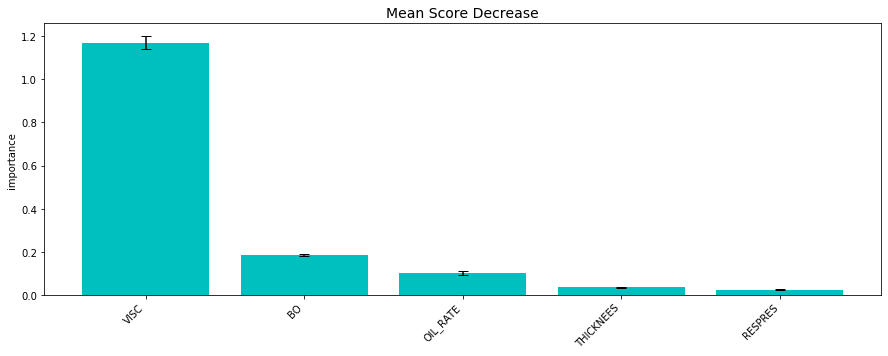

In [36]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [37]:
#MEAN ABSOLUTE ERROR (MAE)

In [38]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['RESPRES', 'OIL_RATE', 'BO', 'VISC', 'THICKNEES']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring= 'neg_mean_absolute_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s


{'algo__colsample_bytree': 0.9763799669573133, 'algo__gamma': 3, 'algo__learning_rate': 0.05820013372709852, 'algo__max_depth': 4, 'algo__n_estimators': 163, 'algo__reg_alpha': 0.07362945281639222, 'algo__reg_lambda': 2.752717392942944, 'algo__subsample': 0.6401537692938899}
-0.3844622330201173 -0.6932981242812685 -0.5269644068902767


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished


In [39]:
#MEAN SQRT ERROR (MSE)

In [40]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['RESPRES', 'OIL_RATE', 'BO', 'VISC', 'THICKNEES']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring= 'neg_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s


{'algo__colsample_bytree': 0.6024641082463879, 'algo__gamma': 7, 'algo__learning_rate': 0.04764963542138517, 'algo__max_depth': 3, 'algo__n_estimators': 118, 'algo__reg_alpha': 0.8013508750140631, 'algo__reg_lambda': 3.8765111709116367, 'algo__subsample': 0.7435432121325587}
-2.589981194180276 -4.613116032174271 -1.224374390033292


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished


In [41]:
save_model(model.best_estimator_, "Predict_Effective-Oil-Permeability_Ko")

Model is pickled as model/Predict_Effective-Oil-Permeability_Ko
